<a href="https://colab.research.google.com/github/aetev/Learning-stuff-/blob/main/CNN%20distribution.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
pip install pandas-ta

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.1/115.1 kB 2.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pandas-ta: filename=pandas_ta-0.3.14b0-py3-none-any.whl size=218908 sha256=7a031a7d4a016df2792ef3bf23094ea2d2cab38d64960015f1da6d4b1d4bdbbb
  Stored in directory: /root/.cache/pip/wheels/69/00/ac/f7fa862c34b0e2ef320175100c233377b4c558944f12474cf0
Successfully built pandas-ta


In [20]:
import tensorflow as tf
import tensorflow_probability as tfp
import pandas_ta as ta
import numpy as np
import pandas as pd
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dropout, Dense
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
df = pd.read_csv("/content/drive/MyDrive/eurusd_hour.csv")
print(df)

             Date   Time       BO       BH       BL       BC      BCh  \
0      2005-05-02  00:00  1.28520  1.28520  1.28400  1.28440 -0.00080   
1      2005-05-02  01:00  1.28440  1.28480  1.28390  1.28420 -0.00020   
2      2005-05-02  02:00  1.28430  1.28540  1.28410  1.28510  0.00080   
3      2005-05-02  03:00  1.28510  1.28590  1.28500  1.28510  0.00000   
4      2005-05-02  04:00  1.28520  1.28590  1.28490  1.28550  0.00030   
...           ...    ...      ...      ...      ...      ...      ...   
93079  2020-04-29  18:00  1.08620  1.08851  1.08611  1.08713  0.00093   
93080  2020-04-29  19:00  1.08711  1.08823  1.08659  1.08748  0.00037   
93081  2020-04-29  20:00  1.08747  1.08788  1.08691  1.08708 -0.00039   
93082  2020-04-29  21:00  1.08708  1.08740  1.08699  1.08714  0.00006   
93083  2020-04-29  22:00  1.08728  1.08760  1.08727  1.08743  0.00015   

            AO       AH       AL       AC      ACh  
0      1.28540  1.28540  1.28420  1.28460 -0.00080  
1      1.28460  1

In [60]:
Date = pd.DataFrame()
new = pd.DataFrame()

new['Date'] = pd.to_datetime(df['Date'])
new['Time'] = pd.to_datetime(df['Time'])

Date['day'] = new['Date'].dt.day
Date['month'] = new['Date'].dt.month
Date['weekday'] = new['Date'].dt.weekday
Date['hour_of_day'] = new['Time'].dt.hour

scaler = MinMaxScaler(feature_range=(-1, 1))

# Scale each column individually
for column in Date.columns:
    Date[column] = scaler.fit_transform(Date[[column]])


print(Date.shape)

(93084, 4)


In [69]:
change = df['ACh']
change.name = 'change'
target = df['ACh'].shift(-3)
target.name = 'target'

combined_series = pd.concat([change, target,Date], axis=1)
combined_series = combined_series.dropna(axis=0)

target = combined_series.pop('target')
Change = combined_series

target = target.values

print(Change.shape)

(93081, 5)


In [6]:
def reshape_time_series(data, window_length, stride):
    num_windows = (len(data) - window_length) // stride + 1
    sliding_windows = np.lib.stride_tricks.sliding_window_view(data, window_shape=(window_length,))
    reshaped_data = sliding_windows[:num_windows * stride:stride]

    return reshaped_data

In [74]:
def reshape_time_series_2(data, window_length, stride):
    # Calculate the number of windows
    num_windows = (len(data) - window_length) // stride + 1

    # Create sliding windows
    sliding_windows = np.lib.stride_tricks.sliding_window_view(data, window_shape=(window_length, 5))

    # Reshape the data
    reshaped_data = sliding_windows[:num_windows * stride:stride]
    reshaped_data = reshaped_data.reshape((num_windows, window_length, 5))

    return reshaped_data

In [80]:

Change_win = reshape_time_series_2(Change,20,1)
np.set_printoptions(suppress=True)

# Get the desired shape from the second array
desired_shape = Change_win.shape[0]

# Slice the first array to match the desired shape
target_adju = target[:desired_shape]


print(target_adju.shape)
print(Change_win.shape)


(93062,)
(93062, 20, 5)


In [81]:
def my_dist(params):
    return tfp.distributions.Normal(loc=params[:,0:1], scale=1e-3 + tf.math.softplus(0.05 * params[:,1:2]))

In [82]:
input_length = 20
input_channels = 5
dropout_rate = .2

model = tf.keras.Sequential([
    tf.keras.layers.Conv1D(filters=64, kernel_size=3,strides=2, activation='relu', input_shape=(input_length, input_channels)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv1D(filters=64, kernel_size=3,strides=2, activation='relu', input_shape=(input_length, input_channels)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv1D(filters=64, kernel_size=3,strides=2, activation='relu', input_shape=(input_length, input_channels)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dropout(rate=dropout_rate),
    tf.keras.layers.Dense(units=128, activation='relu'),
    tf.keras.layers.Dropout(rate=dropout_rate),
    tf.keras.layers.Dense(units=2,activation='linear'),  # 2 units for mean and variance
    tfp.layers.DistributionLambda(my_dist)
])
def NLL(y_true, distr):
    return -distr.log_prob(y_true)

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.01), loss=NLL)


In [83]:
def negative_log_likelihood(y_true, y_pred):
  return -tf.reduce_mean(y_pred.log_prob(y_true))
model.compile(optimizer='adam', loss=negative_log_likelihood)

In [ ]:
num_epochs = 10000
model.fit(x=Change_win, y=target_adju,batch_size=64, epochs=num_epochs)

Epoch 1/10000
1455/1455 [==============================] - 13s 9ms/step - loss: -4.5708
Epoch 2/10000
 492/1455 [=========>....................] - ETA: 7s - loss: -4.6043

In [89]:
pred = model.predict(Change_win)

2909/2909 [==============================] - 9s 3ms/step


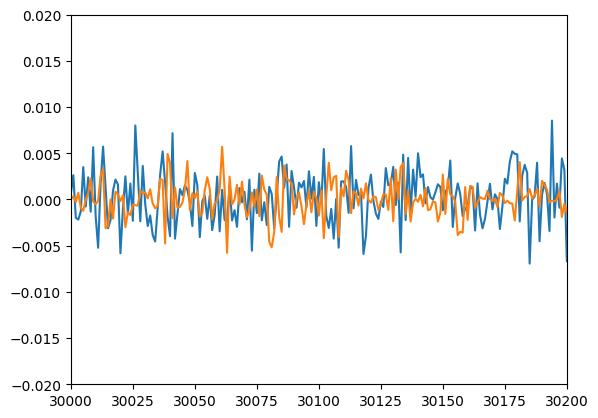

In [93]:
plt.plot(pred)
plt.xlim(30000,30200)
plt.ylim(-.02,.02)
plt.plot(target)